In [11]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
# torhc dataset
from torch.utils.data import Dataset, DataLoader

# train test split
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pandas as pd
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from torchviz import make_dot

#import summary for models 
from torchsummary import summary

import numpy as np

In [12]:
train_test: pd.DataFrame = pd.read_csv('../Data/train_validate.csv')

# # Apply SMOTE to the training set
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# Make a pytorch dataset
class EEGDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  
        self.y = torch.tensor(y, dtype=torch.float32)   

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train, test = train_test_split(train_test, test_size=0.2, random_state=42)
train: pd.DataFrame
X_train = train.drop(columns=train.filter(regex='main.*'))
y_train = train.filter(regex='main.*')
X_validate = test.drop(columns=test.filter(regex='main.*'))
y_validate = test.filter(regex='main.*')
    
train_dataset = EEGDS(X_train.to_numpy(), y_train.to_numpy())
validate_dataset = EEGDS(X_validate.to_numpy(), y_validate.to_numpy())

# data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=False)

In [21]:
X_train.shape

(681, 1140)

In [13]:
class EEGClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, neurons, dropout=0.10):
        super(EEGClassifier, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, neurons[0])
        self.layer2 = nn.Linear(neurons[0], neurons[1])
        self.layer3 = nn.Linear(neurons[1], neurons[2])
        self.layer4 = nn.Linear(neurons[2], neurons[3])
        self.layer5 = nn.Linear(neurons[3], neurons[4])
        self.output_layer = nn.Linear(neurons[4], output_dim)

        self.bn1 = nn.BatchNorm1d(neurons[0])
        self.bn2 = nn.BatchNorm1d(neurons[1])
        self.bn3 = nn.BatchNorm1d(neurons[2])
        self.bn4 = nn.BatchNorm1d(neurons[3])
        self.bn5 = nn.BatchNorm1d(neurons[4])

        self.gelu = nn.GELU()

        self.dropout = nn.Dropout(p=dropout)
        
        init.xavier_uniform_(self.layer1.weight)
        init.xavier_uniform_(self.layer2.weight)
        init.xavier_uniform_(self.layer3.weight)
        init.xavier_uniform_(self.layer4.weight)
        init.xavier_uniform_(self.layer5.weight)
        init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        x = self.gelu(self.bn1(self.layer1(x))) 
        x = self.dropout(x)
        
        x = self.gelu(self.bn2(self.layer2(x)))
        x = self.dropout(x)
        
        x = self.gelu(self.bn3(self.layer3(x)))
        x = self.dropout(x)
        
        x = self.gelu(self.bn4(self.layer4(x)))
        x = self.dropout(x)
        
        x = self.gelu(self.bn5(self.layer5(x)))
        
        x = self.output_layer(x)
        
        return x

In [14]:
model = EEGClassifier(1140, 7, [512, 256, 128, 64, 32], 0.3)
model.eval()
sample_input = torch.randn(1, 1140)  

output = model(sample_input)
output

tensor([[ 0.2832,  0.0561, -0.5036, -0.0946,  0.0121, -0.3185,  0.1605]],
       grad_fn=<AddmmBackward0>)

In [15]:
summary(model, input_size=(1140, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         584,192
       BatchNorm1d-2                  [-1, 512]           1,024
              GELU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
       BatchNorm1d-6                  [-1, 256]             512
              GELU-7                  [-1, 256]               0
           Dropout-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
      BatchNorm1d-10                  [-1, 128]             256
             GELU-11                  [-1, 128]               0
          Dropout-12                  [-1, 128]               0
           Linear-13                   [-1, 64]           8,256
      BatchNorm1d-14                   

In [16]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), 
                       lr=0.00001,
                       weight_decay=1e-5)

scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min', 
                              factor = 0.1, 
                              patience = 3, 
                              min_lr = 1e-5, 
                              verbose = True)

/Users/hamsterlord/.pyenv/versions/3.10.4/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [17]:
for data in train_loader:
    inputs, labels = data
    print(inputs.shape)
    print(labels.shape)
    break

torch.Size([32, 1140])
torch.Size([32, 7])


In [18]:
best_loss = np.inf
patience = 20
min_delta = 0.01
early_stop_counter = 0

train_losses = []
train_accs = []
val_losses = []
val_accs = []
final_epoch = 0

num_epochs = 500

for epoch in range(num_epochs):
    
    # train
    model.train()
    running_loss = 0.
    running_accuracy = 0.

    for data in train_loader:
        inputs, labels = data
        
        optimizer.zero_grad()  # zero gradients
        
        outputs = model.forward(inputs)  # input net
        
        #print(type(outputs))
        
        labels = labels.argmax(dim=1)
        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()

        outputs = F.softmax(outputs, dim=1)
        top_p, top_class = outputs.topk(k=1, dim=1)

        equals = top_class == labels.view(*top_class.shape)

        running_accuracy += torch.mean(equals.type(torch.FloatTensor))

        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)  
        accuracy = (predicted == labels).float().mean()
        running_accuracy += accuracy.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_loader)
    train_accs.append(epoch_accuracy)
    
    if epoch % 50 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_accuracy:.4f}")
    train_losses.append(epoch_loss)
    
    # val
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    correct = total = 0

    with torch.no_grad():
        for data in validate_loader:
            inputs, labels = data

            outputs = model(inputs)
            labels = labels.argmax(dim=1).long()

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            
            accuracy = (predicted == labels).float().mean()
            val_accuracy += accuracy.item()

    val_loss /= len(validate_loader)
    val_accuracy /= len(validate_loader)

    if epoch % 50 == 0:
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n")
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    
    # Early stopping
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        early_stop_counter = 0  
        #best_model_state = model.state_dict()  
    else:
        early_stop_counter += 1
    
    # if early_stop_counter >= patience:
    #     print(f"Early stopping at epoch {epoch+1}.")
    #     final_epoch = epoch+1
    #     #model.load_state_dict(best_model_state) 
    #     break
        
    scheduler.step(val_loss)

Epoch [1/500], Loss: 2.2346, Acc: 0.2686
Validation Loss: 2.0423, Validation Accuracy: 0.0923

Epoch [51/500], Loss: 2.0316, Acc: 0.3753
Validation Loss: 2.0452, Validation Accuracy: 0.0777

Epoch [101/500], Loss: 1.8994, Acc: 0.4861
Validation Loss: 2.0151, Validation Accuracy: 0.0985

Epoch [151/500], Loss: 1.9254, Acc: 0.4350
Validation Loss: 1.9845, Validation Accuracy: 0.1444

Epoch [201/500], Loss: 1.7732, Acc: 0.6143
Validation Loss: 1.9679, Validation Accuracy: 0.1397

Epoch [251/500], Loss: 1.7524, Acc: 0.6209
Validation Loss: 1.9351, Validation Accuracy: 0.1960

Epoch [301/500], Loss: 1.6425, Acc: 0.7693
Validation Loss: 1.9390, Validation Accuracy: 0.2159

Epoch [351/500], Loss: 1.6183, Acc: 0.7872
Validation Loss: 1.9285, Validation Accuracy: 0.2263

Epoch [401/500], Loss: 1.5290, Acc: 0.8131
Validation Loss: 1.9207, Validation Accuracy: 0.2216

Epoch [451/500], Loss: 1.5314, Acc: 0.8542
Validation Loss: 1.9231, Validation Accuracy: 0.2576



In [20]:
max(val_accs)

0.2935606042544047

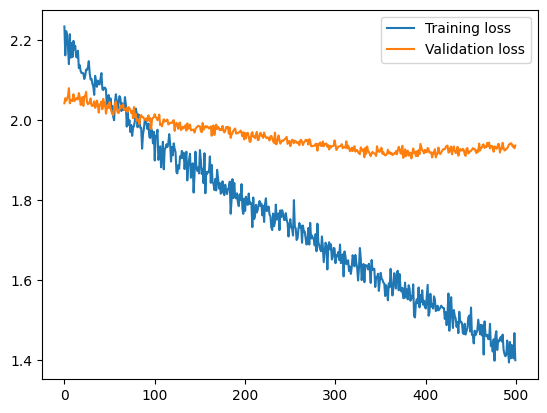

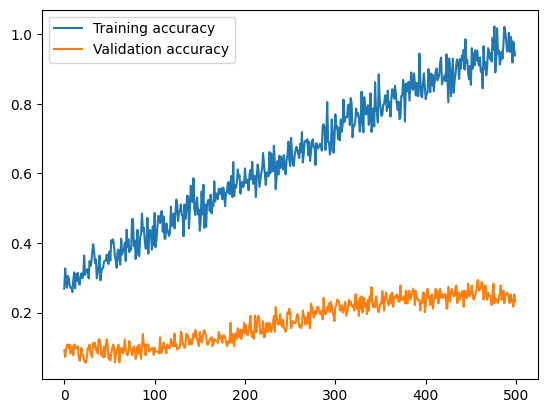

In [19]:
# plot accuracy and loss
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.legend()
plt.show()